
# Segmentação
Referências: <br>
https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html <br>
https://scikit-image.org/docs/dev/api/skimage.segmentation.html
***

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from skimage.segmentation import felzenszwalb,slic,quickshift,watershed
from skimage.color import rgb2gray
from skimage.filters import sobel

In [3]:
import time 

last_time  = time.time()
#function of time, milliseconds of last tic() 
#reset difine if you want clear the clock for ne next tic()
def tic(reset = True):
    global last_time
    toc = time.time()
    delta = toc - last_time
    if reset:
        last_time = toc
    return delta*1000

In [4]:
def pinta_contorno(im_contornar, contorno, lineThickness=1):
    im_contorno = im_contornar.copy()
    return cv2.drawContours(im_contornar, [contorno], 0, (0,0,0), lineThickness)

## Funcoes de imshow

In [5]:
#minha funcao para mostrar as imagens
def imshow(im,big=False):
    if big:
        plt.figure(figsize=(20,20))
    else:
        plt.figure()
    if len(im.shape)<3:
        plt.imshow(im, cmap='gray')#As cores ficam zoadas no Jupyter se deixar sem esse parâmetro
    else:
        plt.imshow(im[:,:,::-1]) 
    plt.axis('off')
    plt.show()

In [6]:
#pinta uma matriz de labels com cores diferentes
def pinta_blobs(labels,angle_delta=20):
    #cria imagens
    im_hsv = np.ones((labels.shape[0],labels.shape[1],3)).astype('uint8')*255
    
    #printa usando a mascara
    im_hsv[:,:,0] = (labels*angle_delta)%180

    return cv2.cvtColor(im_hsv, cv2.COLOR_HSV2BGR)

#pinta uma matriz de labels com a media de cores de im 
def pinta_blobs2(labels,im):
    n_labels = int(labels.max()+1)
    im_out = np.zeros(im.shape)
    
    #divide por canal
    b,g,r    = im[:,:,0],im[:,:,1],im[:,:,2]
    bo,go,ro = im_out[:,:,0],im_out[:,:,1],im_out[:,:,2]
    
    for label in range(n_labels):
        mask = labels==label
        bo[mask] += np.median(b[mask])#b[mask].mean()
        go[mask] += np.median(g[mask])#g[mask].mean()
        ro[mask] += np.median(r[mask])#r[mask].mean()
    return im_out.astype('uint8')

## Abre imagem

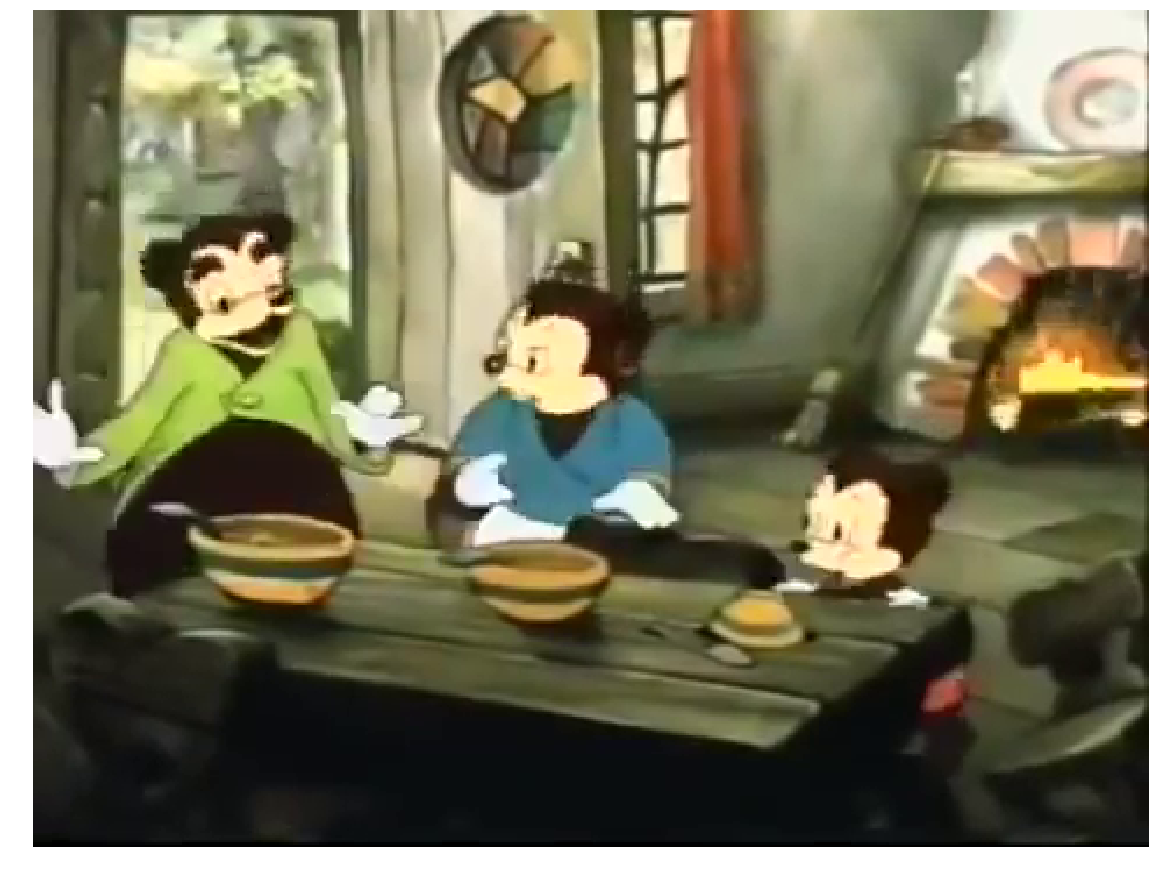

In [132]:
im = cv2.imread('imgs/spaghetti.png')
imshow(im, True)

***
# Quickshift

In [151]:
regioes = quickshift(im, kernel_size=3, max_dist=4, ratio=1)

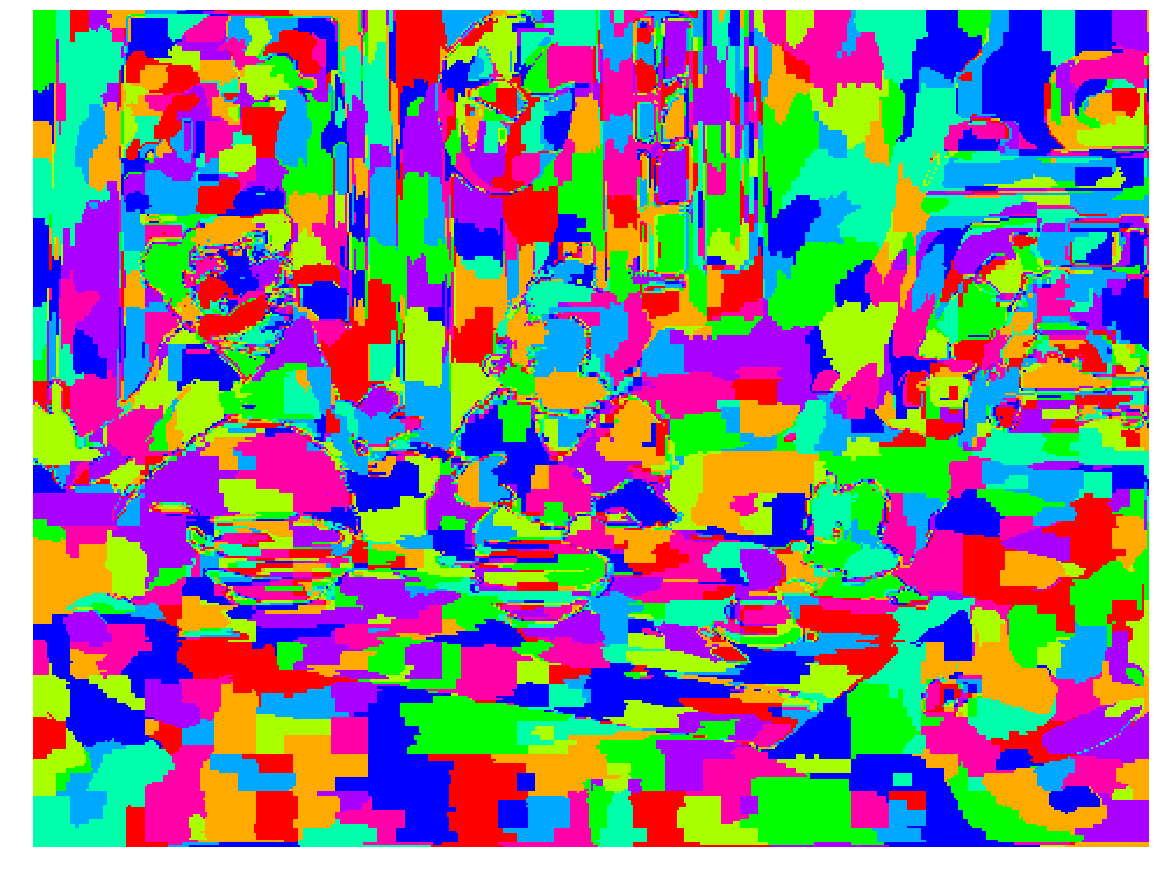

In [152]:
imshow(pinta_blobs(regioes), True)

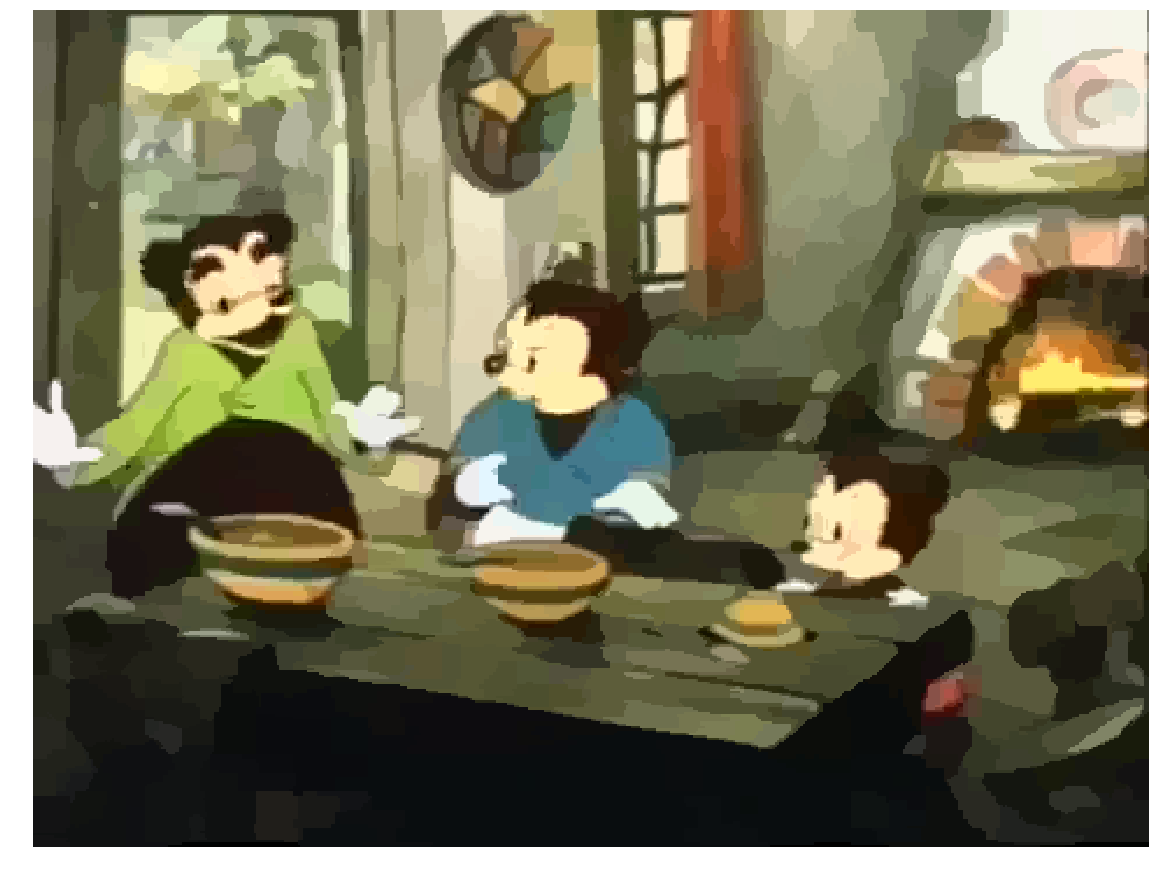

In [153]:
imshow(pinta_blobs2(regioes,im), True)

In [154]:
def encontra_contornos(regioes):
    contornos_por_regiao = []
    
    for i in range(regioes.max() + 1):
        mascara = (regioes == i).astype("uint8") * 255
        contornos,h = cv2.findContours(mascara, mode=cv2.RETR_TREE, method = cv2.CHAIN_APPROX_SIMPLE)
        contornos_por_regiao.append(contornos)

    return contornos_por_regiao

contornos_por_regiao = encontra_contornos(regioes)

### Visualização dos contornos encontrados

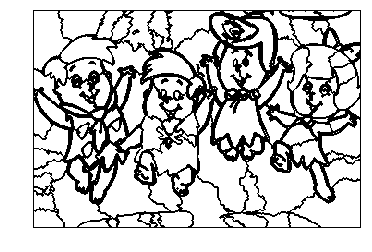

In [55]:
im_branca = np.ones(im.shape).astype('uint8')*255
for contornos_da_regiao in contornos_por_regiao:
    for contorno in contornos_da_regiao:
        im_branca = pinta_contorno(im_branca, contorno, 1)

imshow(im_branca)

In [103]:
def comparar(val):
    return val[4]

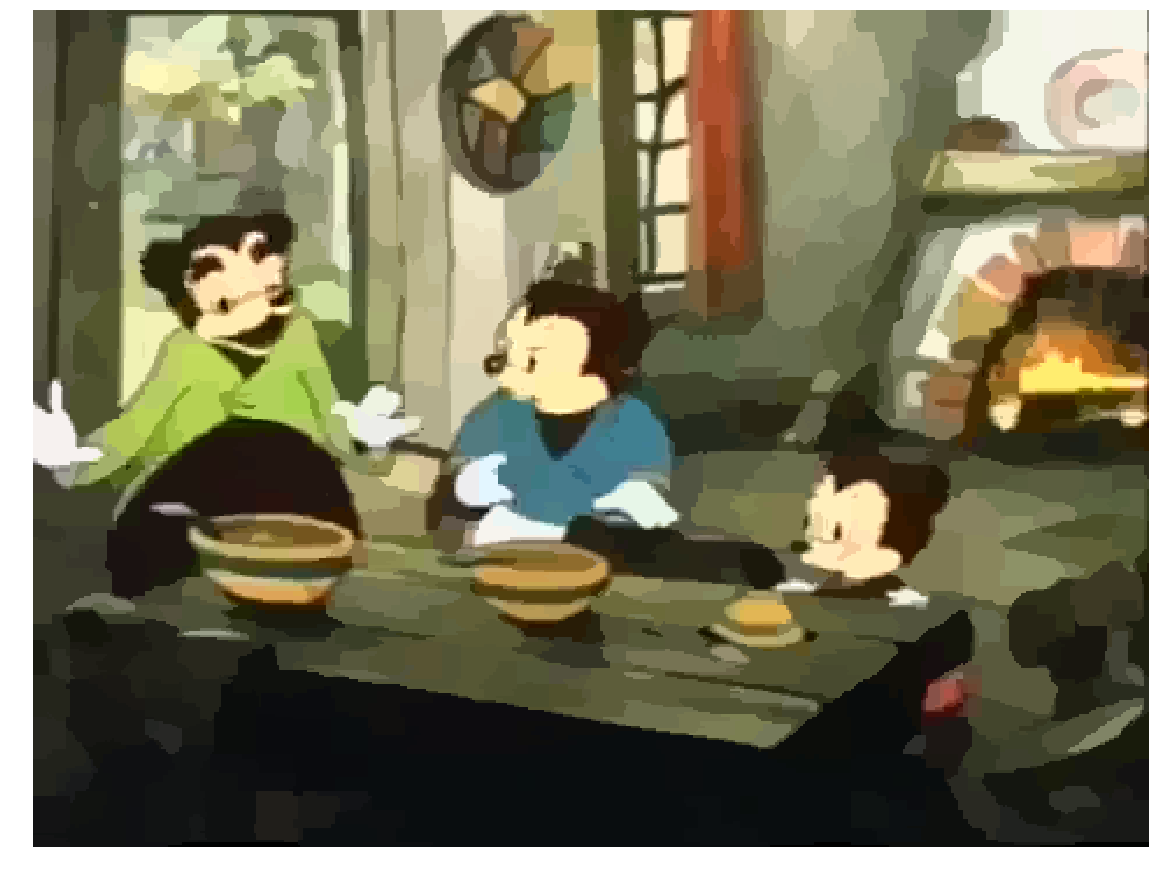

In [155]:
def pinta_regioes(im_original, proporcao, regioes, contornos_por_regiao):
    im_out = np.ones((im_original.shape[0] * proporcao, im_original.shape[1] * proporcao, im_original.shape[2])).astype(float)
    im_out *= -1

    #divide por canal
    b,g,r = im_original[:,:,0], im_original[:,:,1], im_original[:,:,2]
    cores = []
    for label_regiao in range(regioes.max()+1):
        mask = (regioes == label_regiao)
        bo = np.median(b[mask]) / 255.0
        go = np.median(g[mask]) / 255.0
        ro = np.median(r[mask]) / 255.0
        cores.append((bo, go, ro, label_regiao, mask.sum()))
    
    cores.sort(key = comparar, reverse = True)
    
    for cor in cores:
        for contorno in contornos_por_regiao[cor[3]]:
            cv2.drawContours(im_out, [contorno * proporcao], 0, cor[0:3], -1) #Pintar a região
            cv2.drawContours(im_out, [contorno * proporcao], 0, cor[0:3], proporcao) #Pintar a borda
    
    #mask = im_out == -1
    #im_out[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), im_out[~mask])
    
    #kernel = np.ones((3,3), np.float32) / 8
    #kernel[1,1] = 0
    #im_filtro = cv2.filter2D(im_out, -1, kernel)
    #im_out = np.where(im_out == -1, im_filtro, im_out)
    
    return im_out

im_regioes_pintadas = pinta_regioes(im, 1, regioes, contornos_por_regiao)
imshow(im_regioes_pintadas, True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


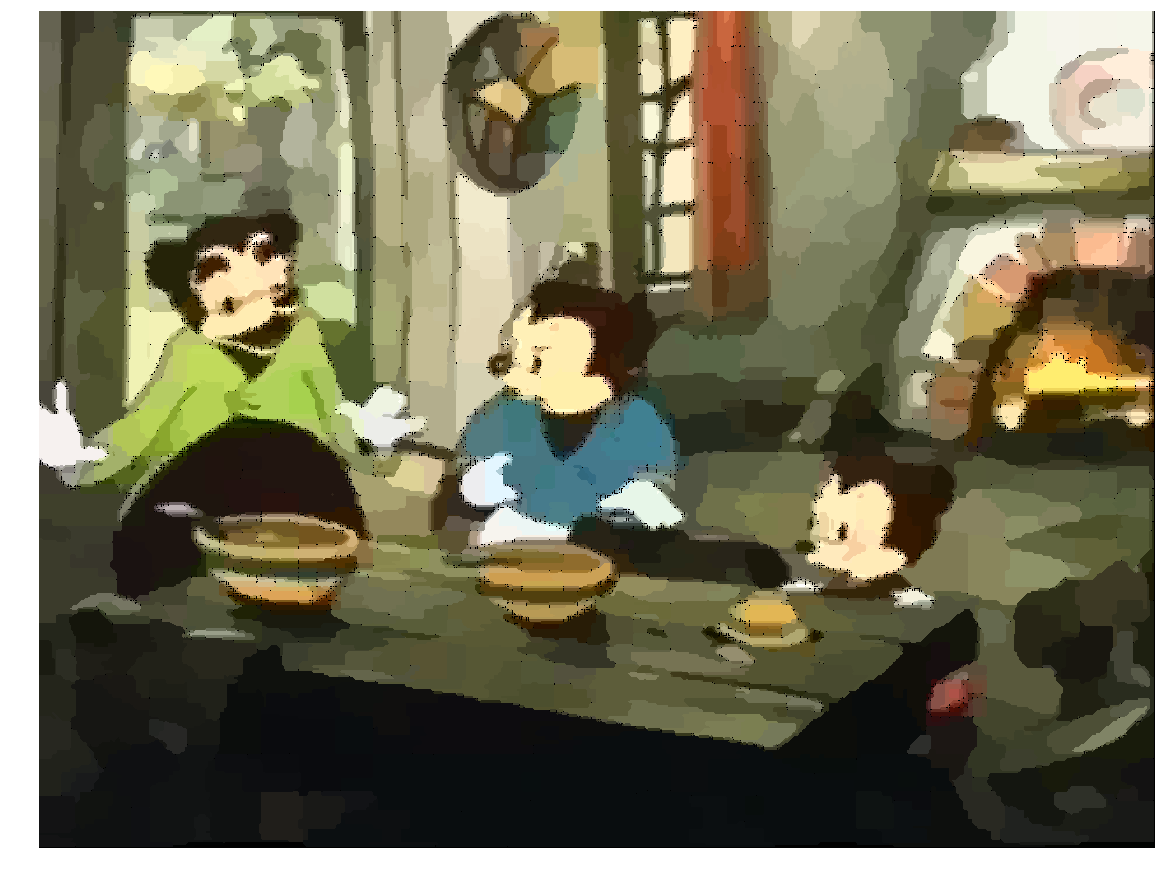

In [156]:
im_regioes_pintadas_4x = pinta_regioes(im, 4, regioes, contornos_por_regiao)
imshow(im_regioes_pintadas_4x, True)

In [157]:
mascara = (im_regioes_pintadas_4x[:,:,0] == -1).astype('uint8')

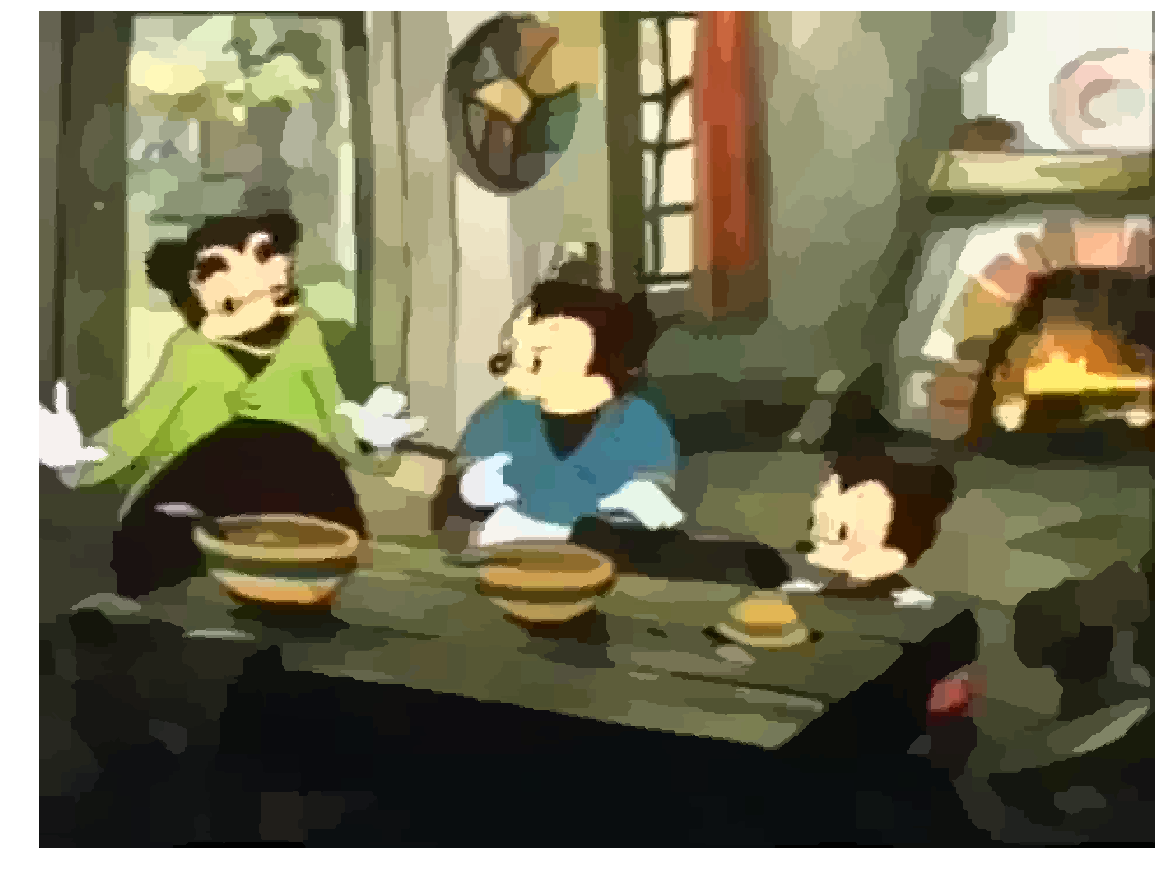

In [158]:
im_saida = im_regioes_pintadas_4x.copy()
im_saida[im_saida == -1] = 0
im_saida = (im_saida * 255).astype('uint8')
im_saida = cv2.inpaint(im_saida, mascara, 3, cv2.INPAINT_NS)
imshow(im_saida, True)

In [159]:
cv2.imwrite('imgs/spaghetti_pontinhos.png',((im_regioes_pintadas_4x) * 255).astype('uint8'))
cv2.imwrite('imgs/spaghetti_inpainting.png',im_saida)

True

## Pipeline

In [ ]:
def pipeline1(path):
    img = cv2.imread(path)
    regioes_img = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
    contornos_por_regiao_img = encontra_contornos(regioes_img)
    img_regioes_pintadas_4x = pinta_regioes(img, 4, regioes_img, contornos_por_regiao_img)
    imshow(img_regioes_pintadas_4x, True)
    
    return img_regioes_pintadas_4x

In [ ]:
def testa_pipeline(pipeline,paths):
    for path in paths:
        print(path)
        im = pipeline(path)
        #imshow(im,True)
        #cv2.imwrite(path+'.png',im[:,:,::-1])

In [ ]:
%%time
paths = ["imgs/flinstones.jpg","imgs/avatar.png","imgs/spaghetti.png"]
testa_pipeline(pipeline1,paths)